#Классификация изображений

Сегодня нам предстоить классифицировать вещи, представленные ниже. Далее можно найти ссылку на папку гугл диска, где хранятся словари для моделей и файлы

https://drive.google.com/drive/folders/1mzxmbcL6CrgnZnFLykA4Yt9erCcPDl2O?usp=sharing



# Подготовка данных

Классы:
0. Экран
1. Кружка
2. Мышь
3. Стул
4. Клавиатура
5. Тарелка
6. Розетка
7. Провода 

In [1]:
classes = ['screen', 'mug','mouse', 'chair', 'keyboard', 'plate', 'socket', 'wires']
n_classes = len(classes)

In [2]:
import torch
torch.__version__

'2.0.0+cu118'

In [3]:
!nvidia-smi

Fri Apr  7 11:35:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import torchvision
import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = torch.device("cpu")
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


In [6]:
# удалим старую версию и установим новую
# !pip uninstall -y Pillow
# !pip install Pillow==5.3.0
# !pip install Pillow
import PIL

In [7]:
print(PIL.PILLOW_VERSION)

8.4.0


<ipython-input-7-e9b25fac4983>:1: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in Pillow 9 (2022-01-02). Use __version__ instead.
  print(PIL.PILLOW_VERSION)


In [8]:
from google.colab import drive
drive.mount('/content/gdrive/')
!ls -l /content/gdrive/MyDrive/classification/my_data
# !unzip -q /content/gdrive/MyDrive/classification/

Mounted at /content/gdrive/
total 32
drwx------ 2 root root 4096 Dec 22 21:28 0_screen
drwx------ 2 root root 4096 Dec 22 21:29 1_mug
drwx------ 2 root root 4096 Dec 22 21:29 2_mouse
drwx------ 2 root root 4096 Dec 22 21:29 3_chair
drwx------ 2 root root 4096 Dec 22 21:29 4_keyboard
drwx------ 2 root root 4096 Dec 22 21:30 5_plate
drwx------ 2 root root 4096 Dec 22 21:30 6_socket
drwx------ 2 root root 4096 Dec 22 21:30 7_wires


In [9]:
!du -sh /content/gdrive/MyDrive/classification/my_data

87M	/content/gdrive/MyDrive/classification/my_data


In [10]:
torch.cuda.is_available() 

True

В нашем тесте будет несколько сотен картнок, для которых вам будет необходимо предсказать класс.

In [11]:
import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [13]:
# разные режимы датасета 
DATA_MODES = ['train', 'val']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. Картинки разного размера, поэтому приведем их к одному размер (это делает метод  _prepare_sample) 

In [14]:
class MyDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
   
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        
        # if mode=="test":
        #   self.files = sorted(files, key=lambda x: int( x.name.split('.')[0][3:] )) #ввиду специфичного названия файлов в тесте "img001.jpg"

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])

        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [15]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [16]:
TRAIN_DIR = Path('gdrive/MyDrive/classification/my_data')
TEST_DIR = Path('gdrive/MyDrive/classification/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
len_common = len(train_val_files)
# test_files =list(TEST_DIR.rglob('*.png'))

len_common, train_val_files[0]

(438,
 PosixPath('gdrive/MyDrive/classification/my_data/0_screen/photo_10_2022-12-23_00-26-20.jpg'))

In [17]:
train_val_files[1::20]

[PosixPath('gdrive/MyDrive/classification/my_data/0_screen/photo_10_2022-12-23_00-26-27.jpg'),
 PosixPath('gdrive/MyDrive/classification/my_data/1_mug/10174-500x445.jpg'),
 PosixPath('gdrive/MyDrive/classification/my_data/1_mug/60ee53f907b09279.jpg'),
 PosixPath('gdrive/MyDrive/classification/my_data/1_mug/photo_1_2022-12-23_00-26-55.jpg'),
 PosixPath('gdrive/MyDrive/classification/my_data/2_mouse/1115132_1.jpg'),
 PosixPath('gdrive/MyDrive/classification/my_data/2_mouse/700-nw.jpg'),
 PosixPath('gdrive/MyDrive/classification/my_data/2_mouse/photo_2_2022-12-23_00-26-30.jpg'),
 PosixPath('gdrive/MyDrive/classification/my_data/3_chair/19451e0f9c549a726f030f2550dd2b76.jpg'),
 PosixPath('gdrive/MyDrive/classification/my_data/3_chair/700.jpg'),
 PosixPath('gdrive/MyDrive/classification/my_data/3_chair/photo_10_2022-12-23_00-26-23.jpg'),
 PosixPath('gdrive/MyDrive/classification/my_data/4_keyboard/1017274326.jpg'),
 PosixPath('gdrive/MyDrive/classification/my_data/4_keyboard/6083164806.jpg')

In [ ]:
# common_dataset = MyDataset(train_val_files, 'train')

# for i in range(len_common):
#     try:
#       img = common_dataset[i]
#     except:
#       print(common_dataset.files[i]) 


gdrive/MyDrive/classification/my_data/3_chair/ba1093_1.jpg
gdrive/MyDrive/classification/my_data/6_socket/photo_4_2022-12-23_00-26-40.jpg


In [18]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.25)

In [19]:
train_dataset = MyDataset(train_files, mode='train')
val_dataset = MyDataset(val_files, mode='val')

In [20]:
label = 5
train_dataset.label_encoder.inverse_transform([label])

array(['5_plate'], dtype='<U10')

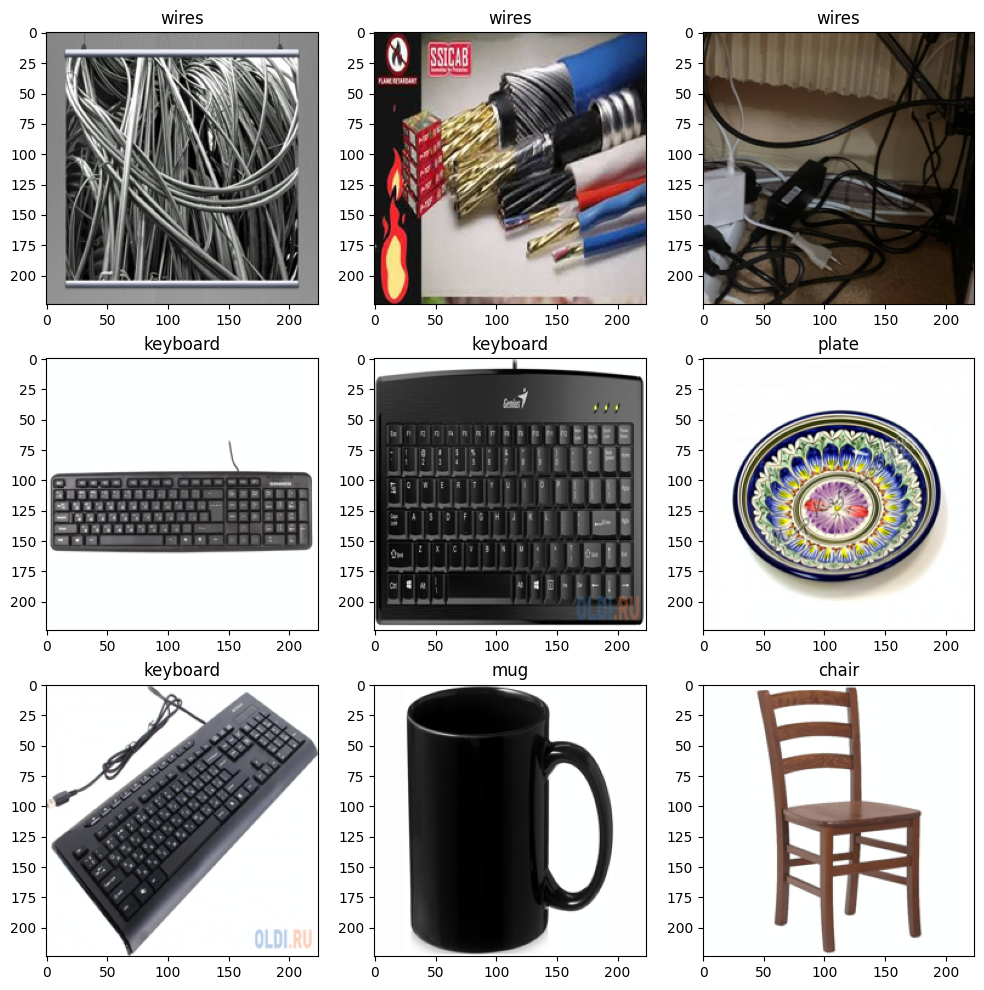

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for fig_x in ax.flatten():
    random_thing = int(np.random.uniform(len(train_dataset)))
    image, label = train_dataset[random_thing]
    
    img_label = train_dataset.label_encoder.inverse_transform([label])[0].split('_')[1]
    
    imshow(image.data.cpu(), title=img_label, plt_ax=fig_x)
    

### Построение нейросети
Данная архитектура содержит блок выделение признаков, 5 слоев. Затем идет 3 линейных слоя




In [22]:
class My_Cnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(96*5*5, 2048),
            nn.ReLU(),
            nn.Dropout(0.25)
            
        )
        self.out = nn.Sequential(
            nn.Linear(2048, n_classes),
        )
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        logits = self.out(x)
        return logits

# Функции тренировки

In [23]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)

        running_corrects += torch.sum(preds == labels)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [24]:
def eval_epoch(model, val_loader, criterion, compliance_classes):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)
        processed_size += inputs.size(0)
        
        for i in range(len(preds)):
          if labels[i] == preds[i]:
            compliance_classes[labels[i]][0]+=1
          else:
            compliance_classes[labels[i]][1]+=1
        

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc, compliance_classes

In [26]:
def train(train_files, val_files, model, epochs, batch_size, opt=None, criterion=None ):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"


    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        if opt is None:
          opt = torch.optim.Adam(model.parameters())
        else:
          opt = opt(model.parameters())
          
        if criterion is None:
          criterion = nn.CrossEntropyLoss()

        compliance_classes = [[0,0] for i in range(n_classes)]  # для отслеживания соотношения у классов

        for epoch in range(epochs):

            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            
            val_loss, val_acc, compliance_classes = eval_epoch(model, val_loader, criterion, compliance_classes)

            history.append((train_loss, train_acc, val_loss, val_acc))
            pbar_outer.update(1)

            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history, compliance_classes

# Создание экземпляра и тренировка

In [28]:
my_cnn = My_Cnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))

print(my_cnn)

we will classify :8
My_Cnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0

In [29]:
val_dataset = MyDataset(val_files, mode='val')
train_dataset = MyDataset(train_files,mode='train')

In [30]:
history, comp_classes = train(train_dataset, val_dataset, model=my_cnn, epochs=7, batch_size=8)

epoch:  14%|█▍        | 1/7 [02:58<17:53, 178.94s/it]


Epoch 001 train_loss: 2.1658     val_loss 2.5169 train_acc 0.4451 val_acc 0.4909


epoch:  29%|██▊       | 2/7 [03:17<07:01, 84.34s/it]


Epoch 002 train_loss: 1.3099     val_loss 1.5117 train_acc 0.6494 val_acc 0.5727


epoch:  43%|████▎     | 3/7 [03:33<03:33, 53.43s/it]


Epoch 003 train_loss: 0.8524     val_loss 1.5552 train_acc 0.7409 val_acc 0.6091


epoch:  57%|█████▋    | 4/7 [03:50<01:56, 38.88s/it]


Epoch 004 train_loss: 0.6497     val_loss 0.8087 train_acc 0.8201 val_acc 0.7636


epoch:  71%|███████▏  | 5/7 [04:06<01:01, 30.83s/it]


Epoch 005 train_loss: 0.3712     val_loss 1.9891 train_acc 0.8841 val_acc 0.5727


epoch:  86%|████████▌ | 6/7 [04:24<00:26, 26.41s/it]


Epoch 006 train_loss: 0.3560     val_loss 1.1177 train_acc 0.8933 val_acc 0.7182


epoch: 100%|██████████| 7/7 [04:41<00:00, 40.20s/it]


Epoch 007 train_loss: 0.3395     val_loss 1.0748 train_acc 0.9024 val_acc 0.7455


# Результат

In [31]:
history[:3]

[(2.1657758122537194,
  0.4451219512195122,
  2.516888403892517,
  tensor(0.4909, device='cuda:0', dtype=torch.float64)),
 (1.309932547371562,
  0.649390243902439,
  1.5117427576671947,
  tensor(0.5727, device='cuda:0', dtype=torch.float64)),
 (0.8524323272541529,
  0.7408536585365854,
  1.5551615933802996,
  tensor(0.6091, device='cuda:0', dtype=torch.float64))]

In [32]:
import seaborn as sns
from matplotlib import pyplot as plt

def history_show(history):  
  t_loss, t_acc, v_loss, v_acc_tens= zip(*history)
  v_acc = [el.cpu() for el in v_acc_tens]

  fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,12))
 
  ax[0].plot(t_loss, label="train_loss")
  ax[0].plot(v_loss, label="val_loss")
  ax[0].legend(loc='best')
  
  ax[1].plot(t_acc, label="train_acc")
  ax[1].plot(v_acc, label="val_acc")
  ax[1].legend(loc='best')
  fig.show()

In [33]:
def value_in_classes(comp_classes):
  probs=[]
  for clas in comp_classes:
    probs.append(clas[0]/(clas[0]+clas[1]))

  fig = plt.figure(figsize=(25,12))

  cls_data = pd.DataFrame()
  cls_data['class'] = pd.Series([classes[i] for i in range(0,8)])
  cls_data['probs'] = pd.Series(probs)

  ax = sns.barplot(data=cls_data, x = 'class', y='probs')

  i=0
  for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2),
    y = height+0.02,
    s = '{:.3f}'.format(probs[i]),
    ha = 'center')
    i = i+1

  plt.show()

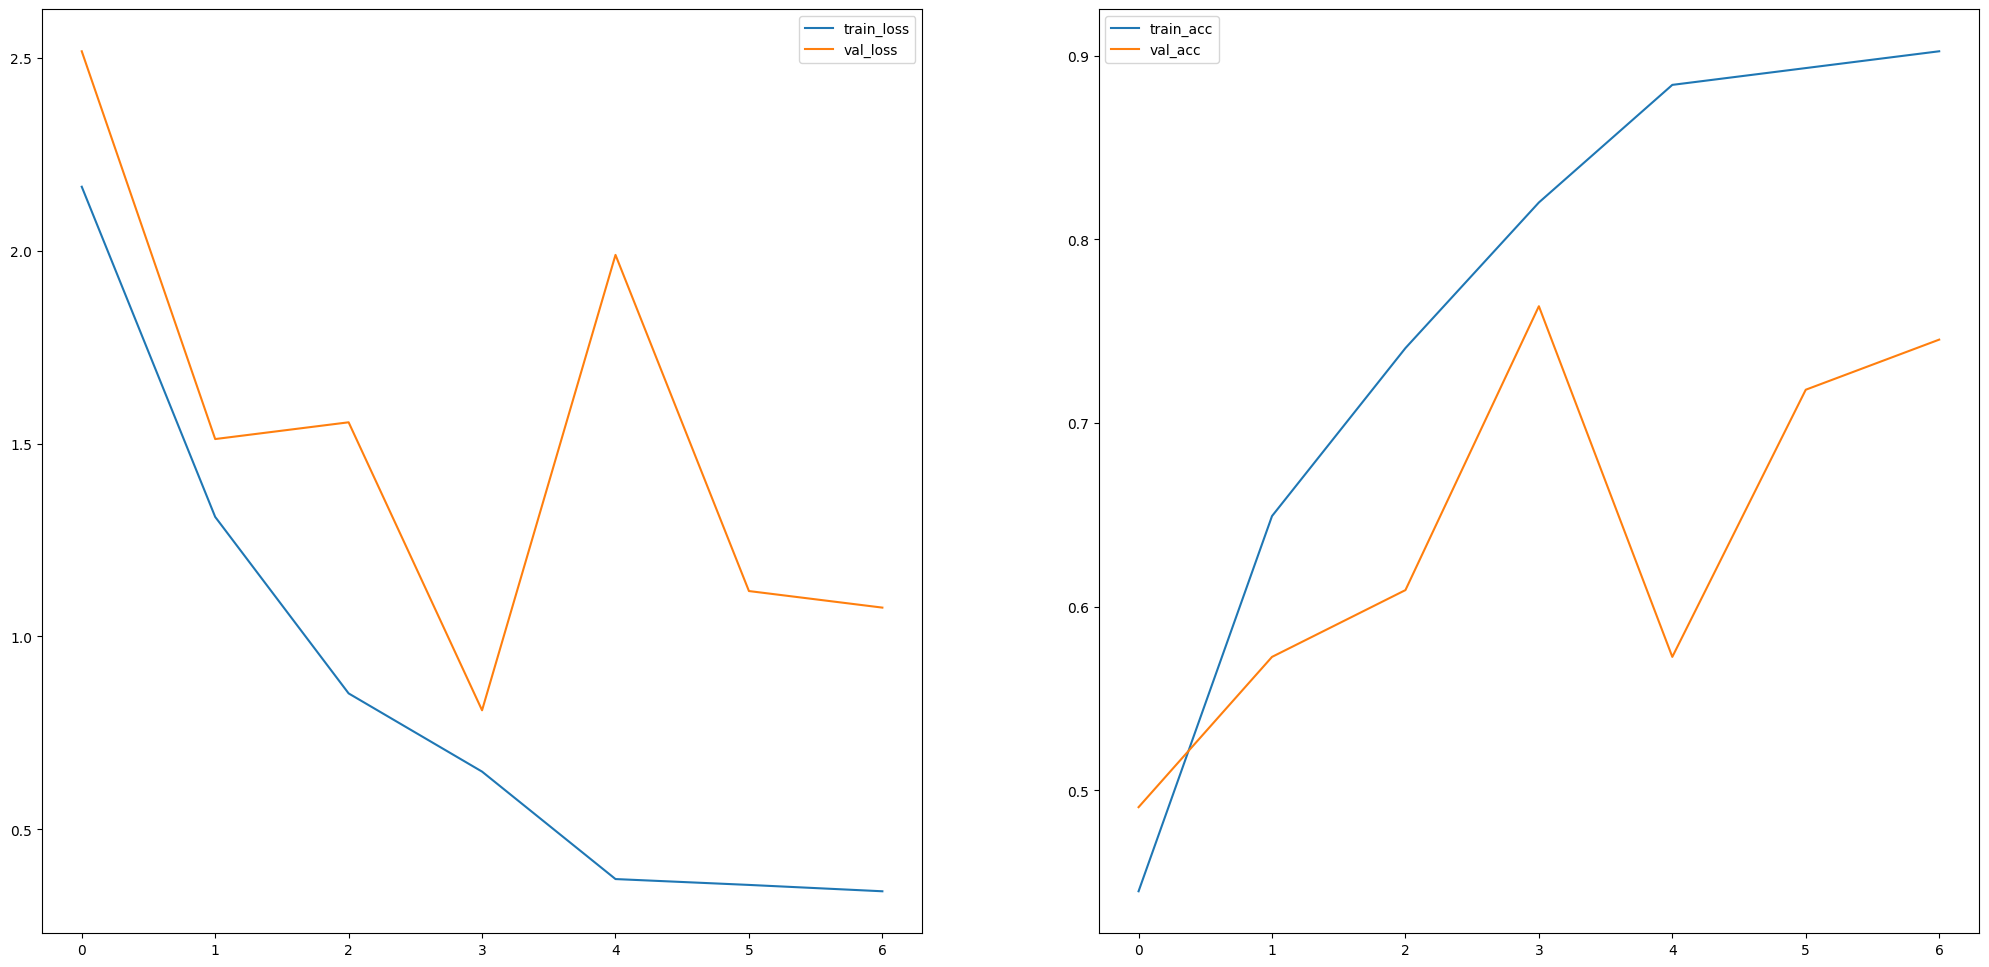

In [34]:
history_show(history)

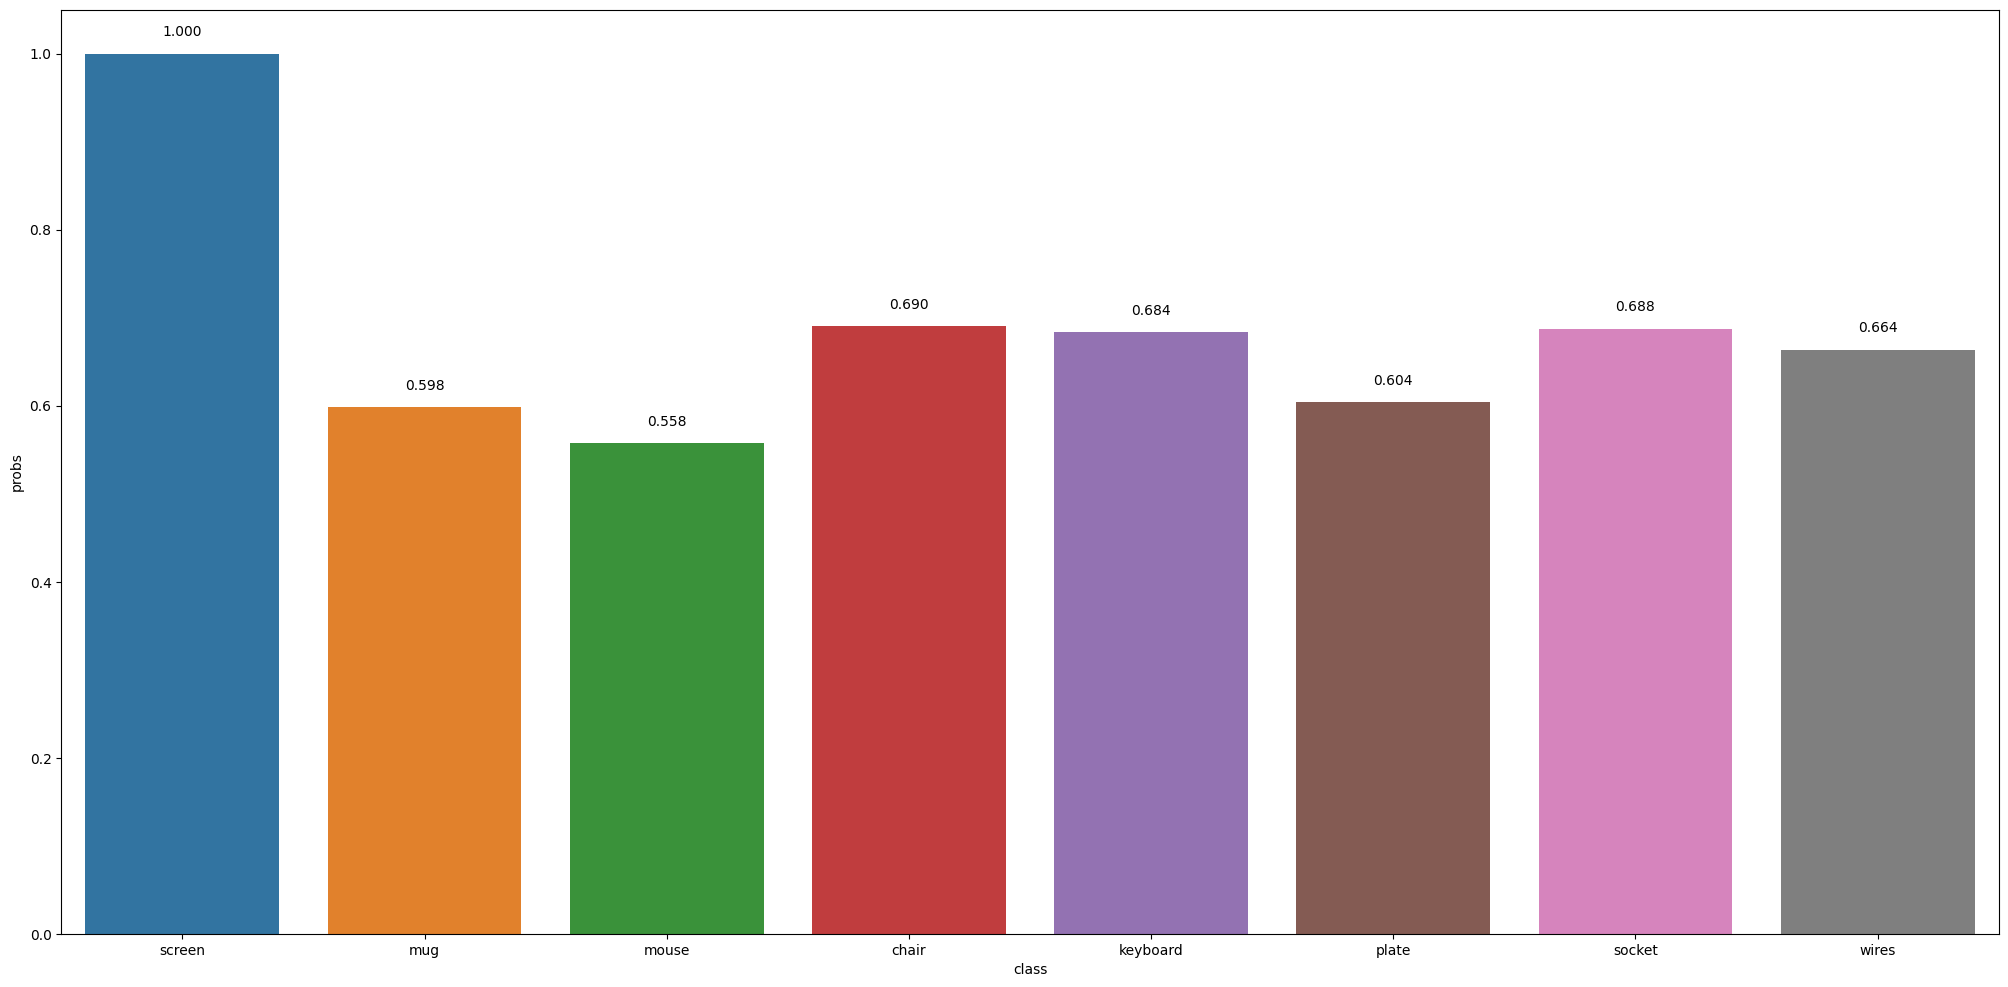

In [35]:
 value_in_classes(comp_classes)

# Сохранение результатов и визулизация

In [36]:
from google.colab import files

torch.save(my_cnn.state_dict(), "/content/gdrive/MyDrive/classification/my_cnn_dict.pth")

model_1 = My_Cnn(n_classes).to(DEVICE)
state_dict = torch.load("/content/gdrive/MyDrive/classification/my_cnn_dict.pth")
model_1.load_state_dict(state_dict)

<All keys matched successfully>

In [37]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
        
    return probs

Сделаем визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. 

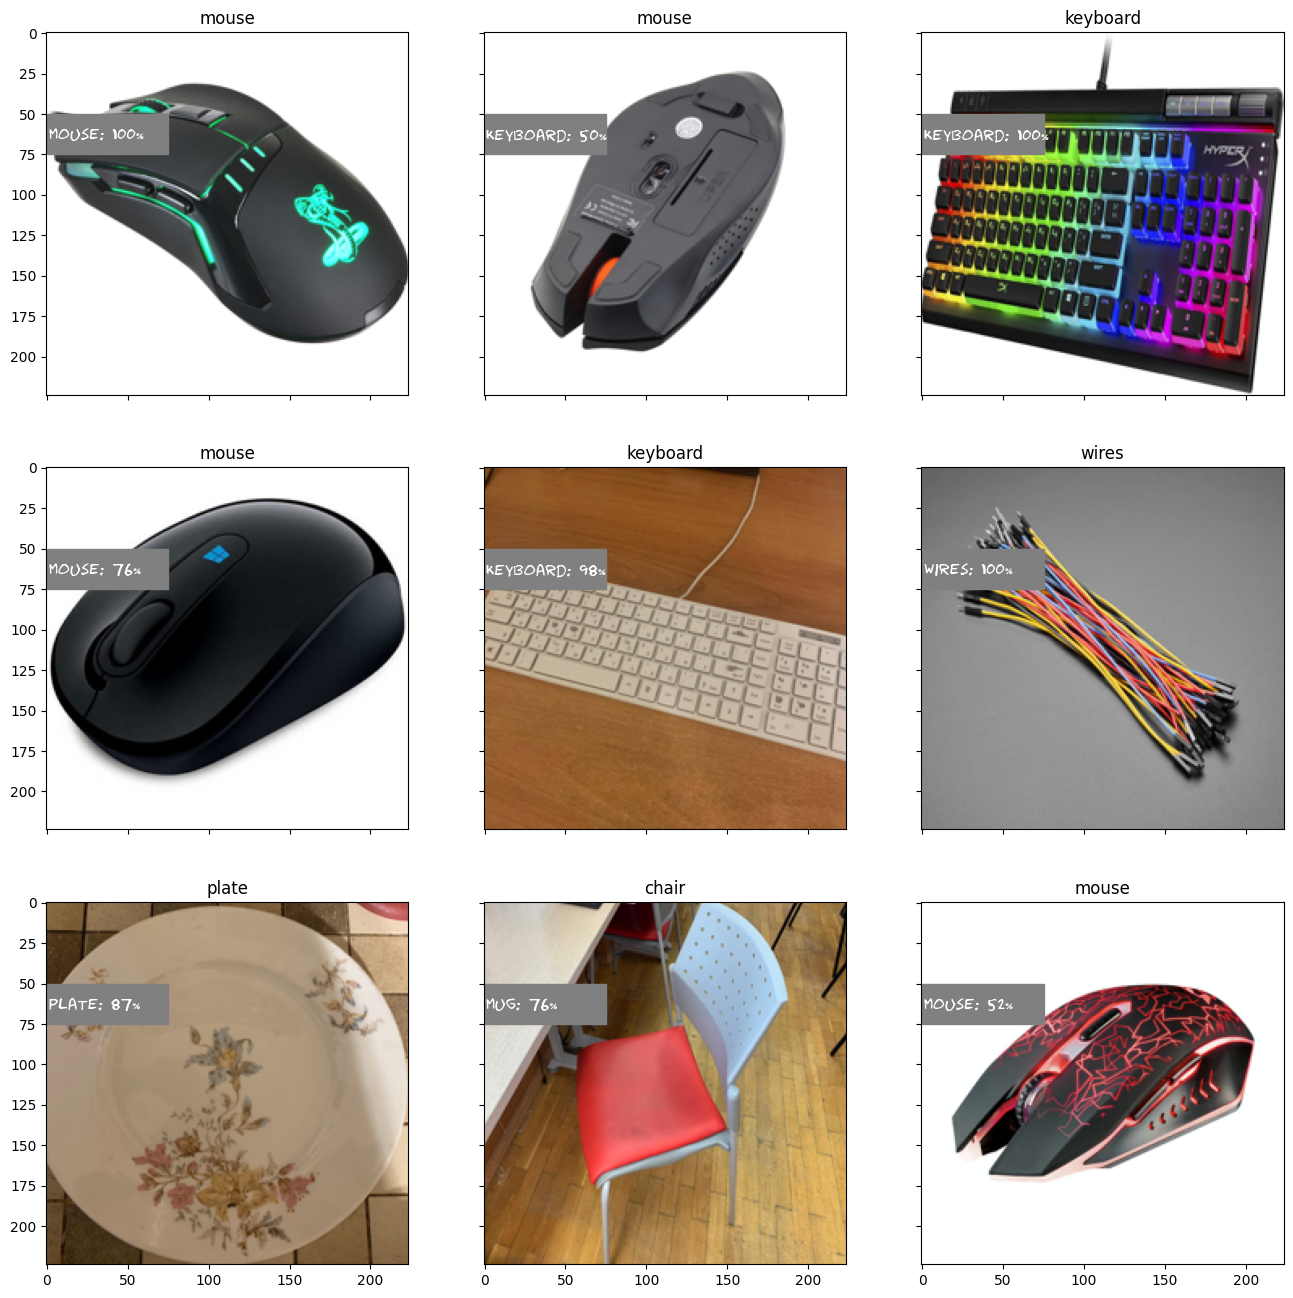

In [38]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_thing = int(np.random.uniform(0,100))
    im_val, label = val_dataset[random_thing]
    img_label = val_dataset.label_encoder.inverse_transform([label])[0].split('_')[1]
    
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)
    
    actual_text = "Actual:{}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 50),75,25,color='grey'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")

    prob_pred = predict_one_sample(model_1, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = val_dataset.label_encoder.classes_[y_pred]
    # predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{}: {:.0f}%".format(predicted_label.split('_')[1] ,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=12, color='white',fontweight='bold')

# Transfer learning

In [39]:
from torchvision import models
model_VGG = models.vgg16(pretrained=True)
for param in model_VGG.parameters():
    param.requires_grad = False
  
num_features = 25088

model_VGG.classifier = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.Linear(4096, n_classes))

model_VGG = model_VGG.cuda()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 135MB/s]


In [40]:
print(model_VGG)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
val_dataset = MyDataset(val_files, mode='val')
train_dataset = MyDataset(train_files,mode='train')

In [45]:
history_2, comp_classes_2 = train(train_dataset, val_dataset, model=model_VGG, epochs=5, batch_size=8)

epoch:  20%|██        | 1/5 [00:20<01:23, 20.76s/it]


Epoch 001 train_loss: 0.5719     val_loss 2.1815 train_acc 0.9909 val_acc 0.9636


epoch:  40%|████      | 2/5 [00:42<01:04, 21.37s/it]


Epoch 002 train_loss: 0.0108     val_loss 1.8487 train_acc 0.9970 val_acc 0.9727


epoch:  60%|██████    | 3/5 [01:03<00:42, 21.04s/it]


Epoch 003 train_loss: 0.0000     val_loss 1.9788 train_acc 1.0000 val_acc 0.9727


epoch:  80%|████████  | 4/5 [01:24<00:21, 21.18s/it]


Epoch 004 train_loss: 0.0000     val_loss 1.9810 train_acc 1.0000 val_acc 0.9727


epoch: 100%|██████████| 5/5 [01:45<00:00, 21.13s/it]


Epoch 005 train_loss: 0.0000     val_loss 1.9810 train_acc 1.0000 val_acc 0.9727


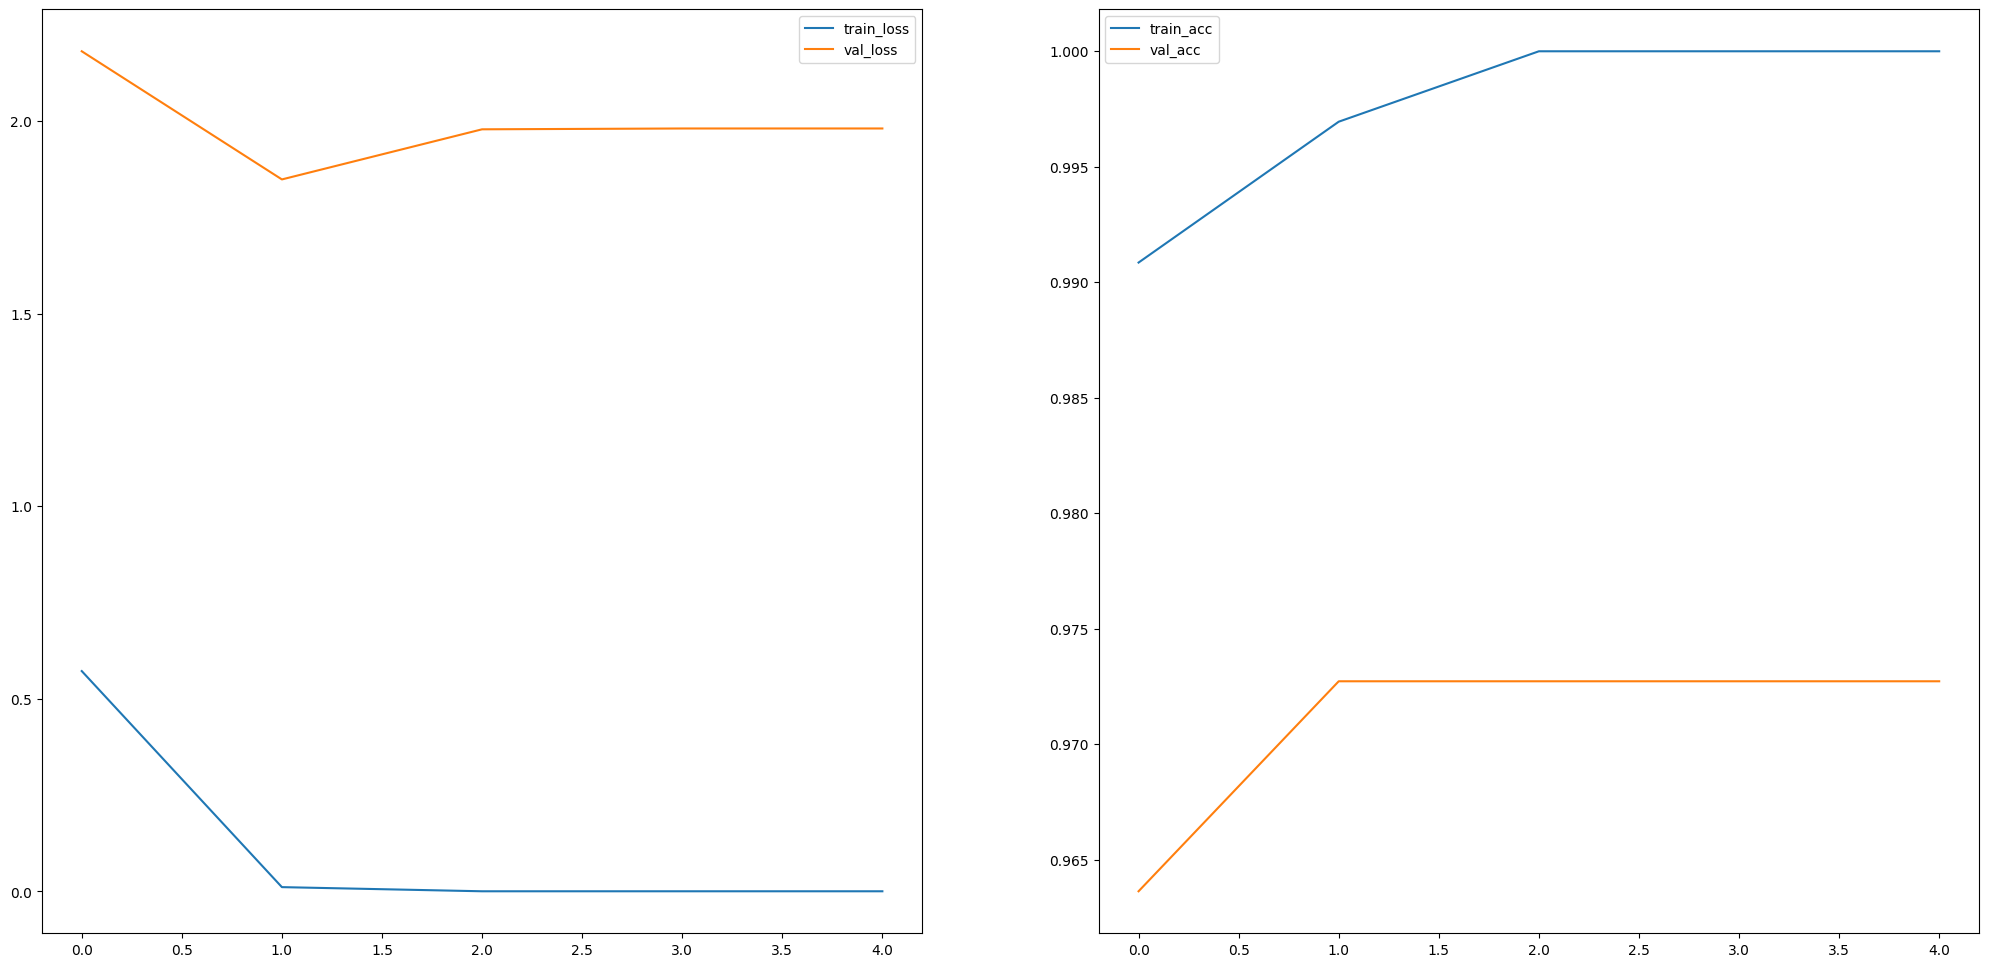

In [46]:
history_show(history_2)

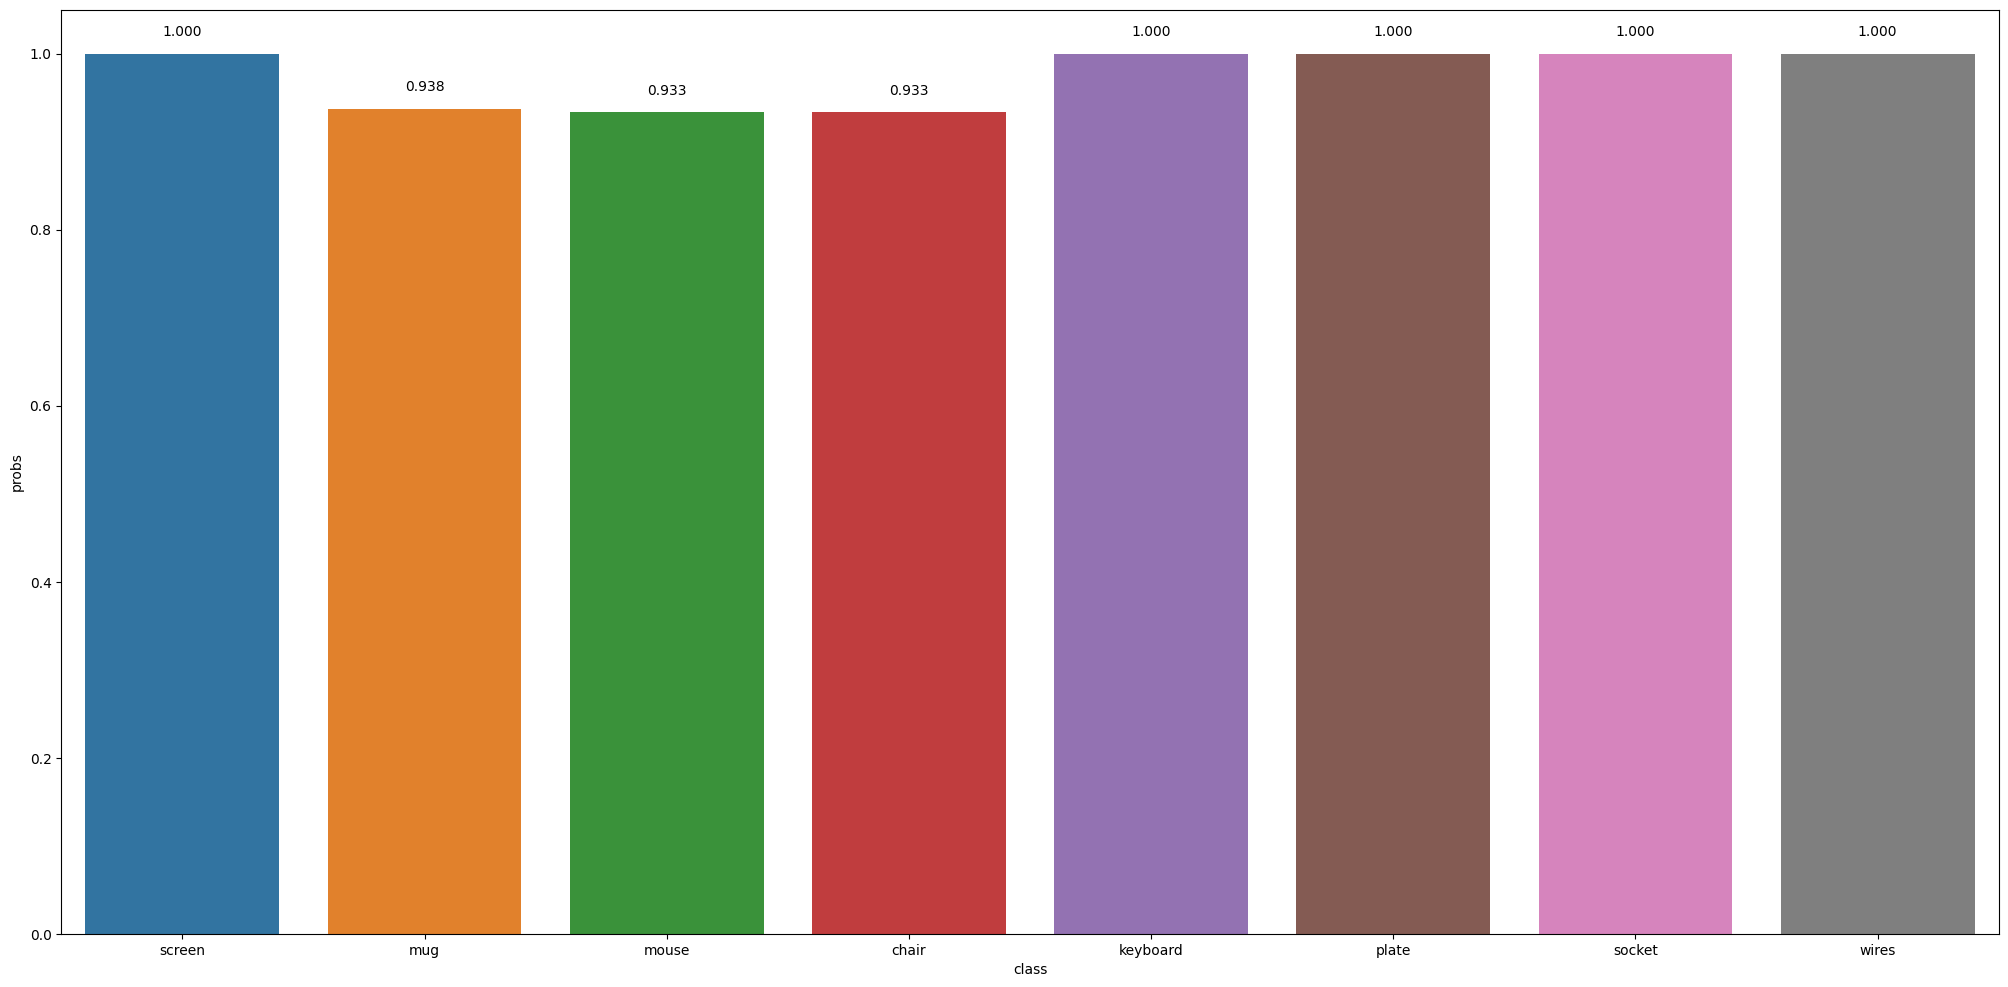

In [47]:
value_in_classes(comp_classes_2)

In [48]:
torch.save(model_VGG.state_dict(), "/content/gdrive/MyDrive/classification/VGG_dict.pth")

model_2 = model_VGG.to(DEVICE)
state_dict = torch.load("/content/gdrive/MyDrive/classification/VGG_dict.pth")
model_2.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# actual_labels=[]
# y_pred=[]

# sum((actual_labels==y_pred).astype(int))/(len(actual_labels))
